In [21]:
from matplotlib import font_manager as fm, rcParams

zh_fonts = [f.name for f in fm.fontManager.ttflist if any(ch in f.name for ch in ['Hei','Song','Sim'])]
if zh_fonts:
    rcParams['font.family'] = zh_fonts[0]  # 使用找到的第一个中文字体
else:
    print("系统中未找到中文字体，中文可能无法显示")

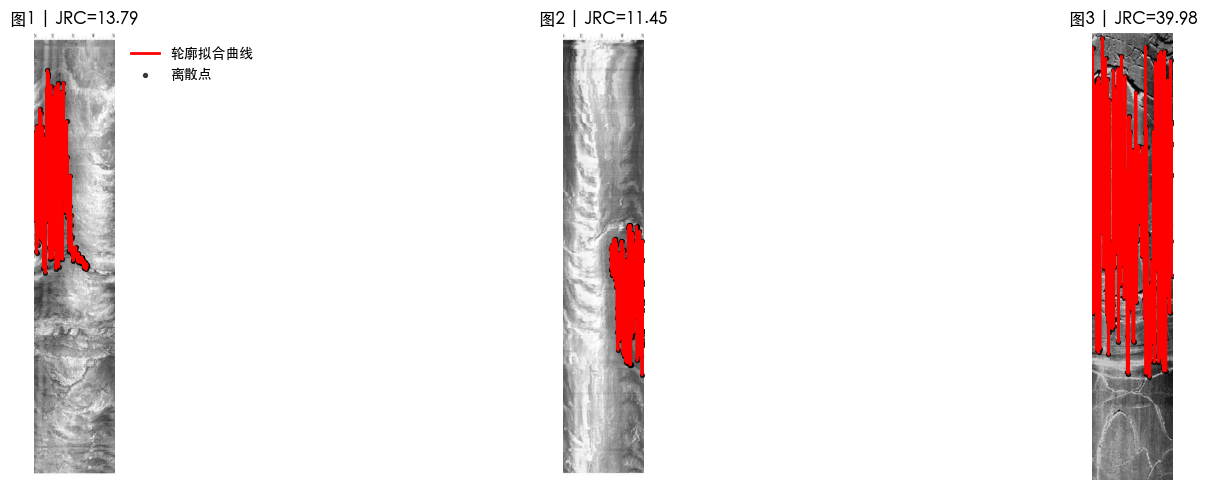

表2已保存为 table2_jrc.csv


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# ------------------ JRC 计算 ------------------
def compute_Z2(points_mm, L=50.0):
    """
    points_mm: np.array (N,2)，单位 mm
    L: 钻孔周长 mm
    """
    x = points_mm[:,0]
    y = points_mm[:,1]
    dx = np.diff(x)
    dy = np.diff(y)
    dx[dx==0] = 1e-6  # 防止除零
    Z2 = np.sum(dy**2 / dx) / L
    return Z2

def compute_JRC(points, pixel_scale=0.1, L=50.0):
    points_mm = points * pixel_scale
    Z2 = compute_Z2(points_mm, L=L)
    JRC = 51.85 * (Z2 ** 0.6) - 10.37
    return JRC


# ------------------ 轮廓提取 ------------------
def extract_contour(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    # 取最长轮廓
    contour = max(contours, key=len).squeeze()
    return contour

# ------------------ 等间距采样 ------------------
def resample_points(points, num=200):
    """按 x 方向等间距采样"""
    x = points[:, 0]
    y = points[:, 1]
    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]
    x_new = np.linspace(x.min(), x.max(), num)
    y_new = np.interp(x_new, x, y)
    return np.vstack([x_new, y_new]).T

# ------------------ 可视化 ------------------
def visualize_cracks(img_paths, scale=0.1, save_path="jrc_result.png"):
    fig, axes = plt.subplots(1, len(img_paths), figsize=(6*len(img_paths), 5))

    records = []  # 表2数据记录

    for i, img_path in enumerate(img_paths):
        contour = extract_contour(img_path)
        if contour is None:
            print(f"未找到轮廓: {img_path}")
            continue
        sampled = resample_points(contour, num=200)
        jrc_val = compute_JRC(sampled, pixel_scale=scale)

        # 保存表格数据
        records.append({
            '图像编号': os.path.basename(img_path),
            '裂隙编号': 1,
            'JRC值': jrc_val
        })

        ax = axes[i] if len(img_paths) > 1 else axes
        ax.imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
        ax.plot(sampled[:, 0], sampled[:, 1], 'r-', linewidth=2, label="轮廓拟合曲线")
        ax.scatter(sampled[:, 0], sampled[:, 1], s=8, c='black', alpha=0.7, label="离散点")
        ax.set_title(f"图{i+1} | JRC={jrc_val:.2f}", fontsize=12)
        ax.axis('off')

        if i == 0:  # 图例只显示一次
            ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), frameon=False)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    # 保存表2 CSV
    df = pd.DataFrame(records)
    df.to_csv("table2_jrc.csv", index=False, encoding='utf-8-sig')
    print("表2已保存为 table2_jrc.csv")

# ------------------ 使用示例 ------------------
img_paths = [
    "./images/attach_3_1.jpg",
    "./images/attach_3_2.jpg",
    "./images/attach_3_3.jpg"
]
pixel_scale = 0.000002  # 每像素对应 mm，可根据实际图像修改

visualize_cracks(img_paths, scale=pixel_scale, save_path="jrc_result.png")
